# Load Modules

In [1]:
from collections import defaultdict

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import sklearn.linear_model
import tqdm
from flax import nnx
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Loading

In [2]:
data = load_diabetes()
print(data["DESCR"])

X, y = data["data"], data["target"].reshape(-1, 1)
X, y = StandardScaler().fit_transform(X), StandardScaler().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

((353, 10), (89, 10))

# Modeling

In [3]:
class Linear(nnx.Module):
    def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):
        key = rngs.params()
        self.w = nnx.Param(jax.random.uniform(key, (din, dout)))
        self.b = nnx.Param(jnp.zeros((dout,)))
        self.din, self.dout = din, dout

    def __call__(self, x: jax.Array):
        return x @ self.w + self.b


class LinearRegressor(nnx.Module):
    def __init__(self, din: int, rngs: nnx.Rngs):
        self.linear = Linear(din, 1, rngs=rngs)

    def __call__(self, x: jax.Array):
        y = self.linear(x)
        return y

# Training

In [4]:
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)
        return jnp.mean((y_pred - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)

    return loss

In [5]:
def train_loop(model, optimizer, X, y, n_epochs=32, n_batch_size=32):
    all_ilocs = np.arange(len(X))
    n_split = len(all_ilocs) // n_batch_size

    with tqdm.trange(1, n_epochs + 1) as progress_bar:
        for epoch in progress_bar:
            ilocs_batches = jnp.array_split(
                jax.random.permutation(jax.random.PRNGKey(epoch), all_ilocs),
                n_split,
            )

            batch_loss = np.zeros(len(ilocs_batches))
            for i, _ilocs in enumerate(ilocs_batches):
                batch_loss[i] = train_step(model, optimizer, X[_ilocs], y[_ilocs])

            progress_bar.set_postfix(dict(epoch_loss=f"{batch_loss.mean():.3f}"))

In [6]:
model = LinearRegressor(X_train.shape[1], rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

train_loop(model, optimizer, X_train, y_train, n_epochs=1000, n_batch_size=128)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.60it/s, epoch_loss=0.481]


# Evaluation

{'flax': 0.8965419941349163, 'sklearn': 0.8965419941349163}


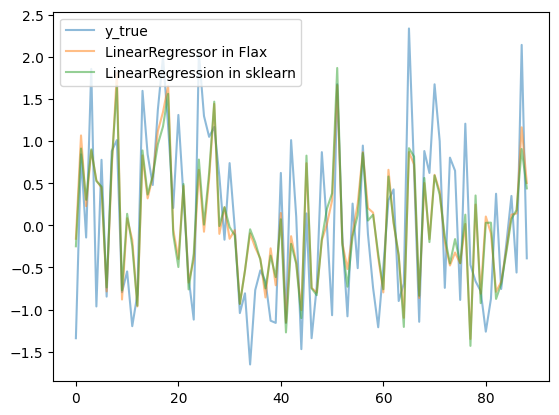

In [7]:
lr = sklearn.linear_model.LinearRegression().fit(X_train, y_train)

plt.plot(y_test, label="y_true", alpha=0.5)
plt.plot(model(X_test), label="LinearRegressor in Flax", alpha=0.5)
plt.plot(lr.predict(X_test), label="LinearRegression in sklearn", alpha=0.5)
plt.legend()

metrics = dict(
    flax=mean_absolute_percentage_error(y_test, model(X_test).ravel()),
    sklearn=mean_absolute_percentage_error(y_test, model(X_test)),
)

print(metrics)